---
# Classificação de Demandas do Fala.BR - Geração de dados com o ChatGPT + BERT
---
**Projeto do Bootcamp Machine Learning (Anderson Monteiro e Léo Maranhão de Mello)**

## Introdução



### **Descrição do projeto de machine learning**


**1- Descrição do problema ou tarefa:**
O problema consiste em classificar as demandas recebidas pela Ouvidoria da SUSEP, por meio do sistema Fala.BR.

**2- Descrição da solução de IA:**
Utilizaremos um processamento de NLP e testaremos modelos de regressão logística e Random Forest para classificação. A solução incluirá uma pipeline que realiza pré-processamento, treinamento e avaliação do modelo.

**3- Fonte de dados:**
A Ouvidoria forneceu um dataset com 1531 textos das demandas e suas classificações, no formato de planilha ODS. A classificação dos textos foi realizada pela própria Ouvidoria.

**4- Variáveis independentes (preditoras ou "features"):**
A variável independente é o texto recebido do Fala.BR.

**5- Variável dependente (resposta ou "target"):**
A variável dependente é a classificação do texto em uma das 17 classificações utilizadas pela Ouvidoria:

- Cadastro
- Capitalização
- Consulta Técnica
- DPVAT/SPVAT
- Não identificada
- Previdência Complementar Aberta
- Seguro Compreensivo
- Seguro de Automoveis
- Seguro de Crédito Interno
- Seguro de Danos
- Seguro de Pessoas
- Seguro de Responsabilidade
- Seguro de Transportes
- Seguro Fiança Locatícia
- Seguro Garantia
- Seguro Garantia Estendida
- Seguro Rural

In [ ]:
# importar bibliotecas
import torch
from transformers import BertTokenizer, BertModel
import torch
from sklearn.linear_model import SGDClassifier
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder
from sklearn.metrics import accuracy_score

import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import confusion_matrix, classification_report, f1_score, ConfusionMatrixDisplay
import numpy as np
from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer, TfidfTransformer
from sklearn.linear_model import SGDClassifier
from sklearn.pipeline import Pipeline
from xgboost import XGBClassifier
from sklearn.model_selection import GridSearchCV
from sklearn.model_selection import RandomizedSearchCV
from sklearn.model_selection import cross_val_score
from imblearn.over_sampling import RandomOverSampler
import re
from sklearn.ensemble import VotingClassifier

import nltk
nltk.download('stopwords')
from nltk.corpus import stopwords

nltk.download('wordnet')
nltk.download('omw-1.4')
from nltk.stem import WordNetLemmatizer

!python -m spacy download pt_core_news_sm
import spacy

# Obtem os sinais de pontuação da língua portuguesa
import string

# instala módulo para ler ods
%pip install odfpy

%pip install optuna
import optuna

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.
[nltk_data] Downloading package wordnet to /root/nltk_data...
[nltk_data] Downloading package omw-1.4 to /root/nltk_data...


     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 13.0/13.0 MB 15.0 MB/s eta 0:00:00
✔ Download and installation successful
You can now load the package via spacy.load('pt_core_news_sm')
⚠ Restart to reload dependencies
If you are in a Jupyter or Colab notebook, you may need to restart Python in
order to load all the package's dependencies. You can do this by selecting the
'Restart kernel' or 'Restart runtime' option.
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 717.0/717.0 kB 8.0 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
  Created wheel for odfpy: filename=odfpy-1.4.1-py2.py3-none-any.whl size=160672 sha256=ea92bc4012cd959ddebcd09fbe15b9032c68d80a9f6d8b2bbba85ef271aeb6a0
  Stored in directory: /root/.cache/pip/wheels/c8/2e/95/90d94fe33903786937f3b8c33dd88807f792359c6424b40469
Successfully built odfpy
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 362.8/362.8 kB 11.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 233.2/233.2 kB 17.6 MB/s eta 0:00:00
   ━━━━━━━━━

## 1- Carregar dados

In [ ]:
# monta o goole drive
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
# Carregar dados da planilha
df = pd.read_excel("/content/drive/MyDrive/Colab Notebooks/bootcamp/dados/Projeto IA - Amostra Anonimizada - Demandas úteis da ouvidoria 2023.ods", engine="odf")


## 2- Análise exploratória dos dados

In [ ]:
# Análise exploratória dos dados
df.head()

,Demanda,Tipo de Resposta,Categoria,Motivo
0,Preciso retirar minha responsabilidade técnica...,Corretores - cadastro,Cadastro,Documentação
1,Prezados.Venho através dessa denunciar a práti...,Mercado não supervisionado,Seguro de Automoveis,Denúncia sobre mercado não supervisionado
2,Quero saber sobre seguro de vida e apolices fe...,Cadastro de segurado,Seguro de Pessoas,Informações/dúvidas sobre produtos/serviços
3,"MUITO BOM DIA, estou recorrendo a este caminho...",Corretores - cadastro,Cadastro,Documentação
4,"Preciso, de uma verificação desta apólice! Apó...",Cadastro de segurado,Seguro de Pessoas,Informações/dúvidas sobre produtos/serviços


In [ ]:
# Descreva a estatística básica da variáveis
df.describe()


,Demanda,Tipo de Resposta,Categoria,Motivo
count,1530,1530,1530,1530
unique,1522,15,17,46
top,Bom dia me chamo T gostaria de uma ajuda para ...,Reclamação - Consumidor.gov.br,Cadastro,Documentação
freq,2,460,470,450


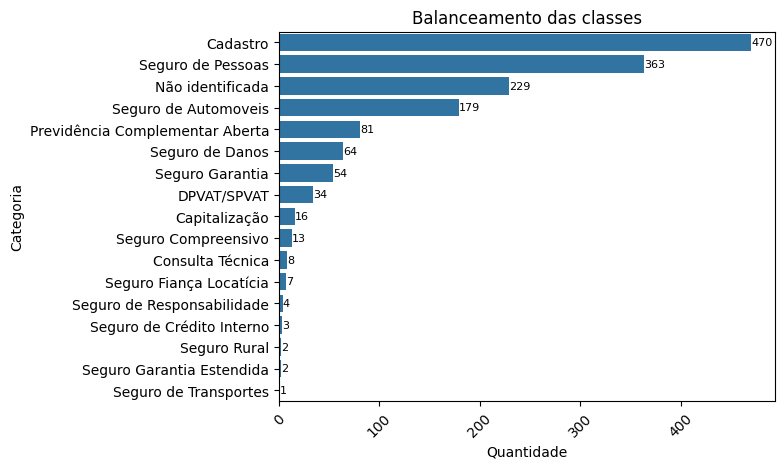

In [ ]:
# Mostrar gráfico com o balanceamento das classes
ax = sns.countplot(y='Categoria', data=df, order=df['Categoria'].value_counts().index)
ax.bar_label(ax.containers[0], fontsize=8)
plt.xticks(rotation=45)
plt.title('Balanceamento das classes')
plt.xlabel('Quantidade')
plt.ylabel('Categoria')
plt.show()


In [ ]:
# Seguro de transporte possui apenas uma ocorrência.
# Por outro lado, capitalização, seguro compreensivo, consulta técnica, seguro fiança locatícia e os seguros de Responsabilidade, Crédito Interno,
# Rural, Garantia Estendida também possuem poucos menos de 5 casos. Iremos criar uma nova categoria, Outros,
# juntando esses seguros de baixa ocorrência.

# Renomear as categorias
df['Categoria'] = df['Categoria'].replace(['Capitalização', 'Seguro Compreensivo', 'Consulta Técnica', 'Seguro Fiança Locatícia', 'Seguro de Transportes', 'Seguro de Responsabilidade', 'Seguro de Crédito Interno', 'Seguro Rural', 'Seguro Garantia Estendida'], 'Outros')


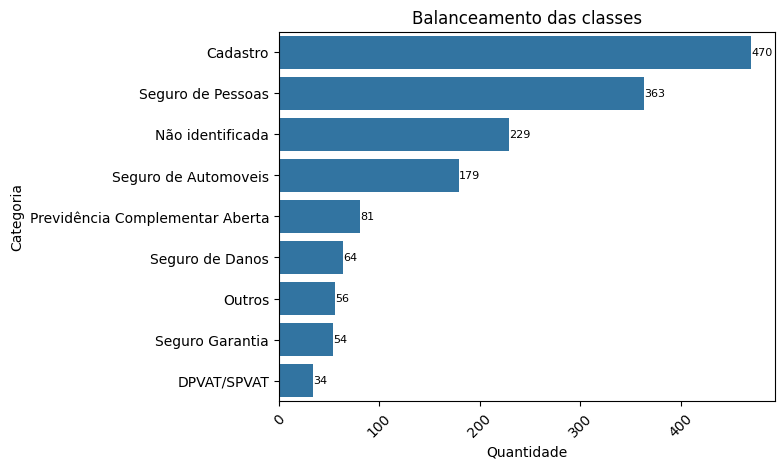

In [ ]:
# Mostrar gráfico com o novo balanceamento das classes
ax = sns.countplot(y='Categoria', data=df, order=df['Categoria'].value_counts().index)
ax.bar_label(ax.containers[0], fontsize=8)
plt.xticks(rotation=45)
plt.title('Balanceamento das classes')
plt.xlabel('Quantidade')
plt.ylabel('Categoria')
plt.show()

In [ ]:
# Bag of Words no sklearn: usamos CountVectorizer
# instancia o transform CountVectorizer
vectorizer = CountVectorizer()

# tokeniza e cria o vocabulário
vectorizer.fit(df['Demanda'])

# mostra o vocabulário criado
print('Vocabulário: ')
print(vectorizer.vocabulary_)

# converte em números
print('\ndimensões da matrix: ')
vector = vectorizer.transform(df['Demanda'])

# mostra as dimensões da matrix de frequência
print(vector.shape)

# mostra os documentos codificados
feature_names = vectorizer.get_feature_names_out()
df_bag = pd.DataFrame(vector.toarray(), columns = feature_names)

# Apresenta os totais das colunas, ordenando em ordem decrescente
df_bag.sum().sort_values(ascending=False)

Vocabulário: 
{'preciso': 8843, 'retirar': 10099, 'minha': 7410, 'responsabilidade': 10025, 'técnica': 11460, 'da': 3307, 'empresa': 4376, 'credenciada': 3156, 'na': 7630, 'susep': 10949, 'não': 7868, 'estou': 4844, 'conseguindo': 2790, 'prezados': 8985, 'venho': 11681, 'através': 1438, 'dessa': 3753, 'denunciar': 3531, 'prática': 9232, 'de': 3363, 'venda': 11659, 'ilegal': 5982, 'seguro': 10443, 'temos': 11101, 'em': 4293, 'americana': 889, 'um': 11489, 'grupo': 5785, 'chamado': 2213, 'motor': 7526, 'home': 5868, 'https': 5908, 'grupomotorhome': 5786, 'com': 2449, 'br': 1833, 'comercializando': 2471, 'proteção': 9182, 'veicular': 11629, 'como': 2496, 'se': 10367, 'fosse': 5472, 'unidade': 11503, 'fica': 5288, 'localizada': 7005, 'rua': 10250, 'são': 10993, 'gabriel': 5603, '333': 1, 'bairro': 1660, 'manoel': 7165, 'diante': 3881, 'do': 4090, 'fato': 5197, 'narrado': 7644, 'solicito': 10744, 'fiscalização': 5376, 'aplicação': 1064, 'das': 3347, 'leis': 6842, 'cabíveis': 1904, 'para': 8

,0
de,7249
que,4596
33,4363
do,2747
não,2591
...,...
federa,1
fechasse,1
fecharam,1
fechamos,1


In [ ]:
# Inicializa BERT

model_name = "neuralmind/bert-base-portuguese-cased"
tokenizer = BertTokenizer.from_pretrained(model_name)
model = BertModel.from_pretrained(model_name)

def get_bert_embeddings(texts, model, tokenizer, max_length=512):
    embeddings = []
    for text in texts:
        # Tokenização
        inputs = tokenizer(text, return_tensors="pt", max_length=max_length, truncation=True, padding="max_length")

        # Gerar embeddings com o modelo BERT
        with torch.no_grad():
            outputs = model(**inputs)

        # Pegamos o vetor do CLS token como embedding da frase
        cls_embedding = outputs.last_hidden_state[:, 0, :].squeeze().numpy()
        embeddings.append(cls_embedding)

    return embeddings


## 3- Preparação dos dados

In [ ]:
# Substituição das categorias de y_train e y_test por dados numéricos
y_mapping = {
    'Cadastro': 0,
    'Seguro de Pessoas': 1,
    'Não identificada': 2,
    'Seguro de Automoveis': 3,
    'Previdência Complementar Aberta': 4,
    'Seguro de Danos': 5,
    'Outros': 6,
    'Seguro Garantia': 7,
    'DPVAT/SPVAT': 8
}

# Defina X e y
X = df['Demanda']
y = df['Categoria'].apply(lambda x: y_mapping[x])

# Dividir os dados em conjuntos de treino e teste
X_train_antes, X_test, y_train_antes, y_test = train_test_split(X, y, test_size=0.2, random_state=42, stratify=y)


In [ ]:
# Inclusão dos dados de treino gerados pelo ChatGPT

X_train_depois = X_train_antes
X_train_depois = pd.DataFrame(X_train_depois, columns=['Demanda'])
y_train_antes = pd.DataFrame(y_train_antes, columns=['Categoria'])
X_train_depois['Categoria'] = y_train_antes['Categoria']
X_train_depois = X_train_depois[X_train_depois['Categoria'] == 0]

X_train_depois.loc[:, 'Categoria']= 'Cadastro' # Coloca a coluna categoria como texto

# Adiciona dados auto
df_treino_novo = pd.read_excel("/content/drive/MyDrive/Colab Notebooks/bootcamp/dados/todas_demandas_auto.ods", engine="odf")
X_train_depois = pd.concat([X_train_depois, df_treino_novo])

# Adiciona dados dpvat
df_treino_novo = pd.read_excel("/content/drive/MyDrive/Colab Notebooks/bootcamp/dados/todas_demandas_dpvat.ods", engine="odf")
X_train_depois = pd.concat([X_train_depois, df_treino_novo])

# Adiciona dados garantia
df_treino_novo = pd.read_excel("/content/drive/MyDrive/Colab Notebooks/bootcamp/dados/todas_demandas_garantia.ods", engine="odf")
X_train_depois = pd.concat([X_train_depois, df_treino_novo])

# Adiciona dados não identificadas
df_treino_novo = pd.read_excel("/content/drive/MyDrive/Colab Notebooks/bootcamp/dados/todas_demandas_nao_identificadas.ods", engine="odf")
X_train_depois = pd.concat([X_train_depois, df_treino_novo])

# Adiciona dados outros
df_treino_novo = pd.read_excel("/content/drive/MyDrive/Colab Notebooks/bootcamp/dados/todas_demandas_outros.ods", engine="odf")
X_train_depois = pd.concat([X_train_depois, df_treino_novo])

# Adiciona dados pessoas
df_treino_novo = pd.read_excel("/content/drive/MyDrive/Colab Notebooks/bootcamp/dados/todas_demandas_pessoas.ods", engine="odf")
X_train_depois = pd.concat([X_train_depois, df_treino_novo])

# Adiciona dados prev privada
df_treino_novo = pd.read_excel("/content/drive/MyDrive/Colab Notebooks/bootcamp/dados/todas_demandas_previdencia_privada.ods", engine="odf")
X_train_depois = pd.concat([X_train_depois, df_treino_novo])

# Adiciona dados danos
df_treino_novo = pd.read_excel("/content/drive/MyDrive/Colab Notebooks/bootcamp/dados/todas_demandas_seguro_danos.ods", engine="odf")
X_train_depois = pd.concat([X_train_depois, df_treino_novo])

# Substituição das categorias de y_train por dados numéricos
y_mapping = {
    'Cadastro': 0,
    'Seguro de Pessoas': 1,
    'Não identificada': 2,
    'Seguro de Automoveis': 3,
    'Previdência Complementar Aberta': 4,
    'Seguro de Danos': 5,
    'Outros': 6,
    'Seguro Garantia': 7,
    'DPVAT/SPVAT': 8
}

# Defina X e y
X_train = X_train_depois['Demanda']
y_train = X_train_depois['Categoria'].apply(lambda x: y_mapping[x])

X_train = pd.DataFrame(X_train, columns=['Demanda'])
X_test = pd.DataFrame(X_test, columns=['Demanda'])

#y_train = pd.DataFrame(y_train, columns=['Categoria'])

### 4 - Gerar os embeddings BERT

In [ ]:
embeddings_treino = get_bert_embeddings(X_train['Demanda'], model, tokenizer)

embeddings_teste = get_bert_embeddings(X_test['Demanda'], model, tokenizer)

## 5- Treinar o modelo

### SGDCClassifier

In [ ]:
# Define o pipeline incluindo: tokenização (TfidfVectorizer) e treinamento do classificador
pipeline = Pipeline([
    ('clf', SGDClassifier(alpha=1e-06, random_state=42))
])

param_grid_sg = {
    'clf__loss': ['log_loss', 'hinge', 'perceptron'],
    'clf__penalty': ['elasticnet', 'l1', 'l2']
}

# Realizar a busca de hiperparâmetros com validação cruzada
grid_search_sg = GridSearchCV(pipeline, param_grid_sg, cv=3, n_jobs=-1, scoring = 'f1_macro')
grid_search_sg.fit(embeddings_treino, y_train)

# Melhor modelo encontrado
best_model_sg = grid_search_sg.best_estimator_
print("Melhores hiperparâmetros:", grid_search_sg.best_params_)

# Mostrar f1 score do melhor estimador
y_pred = best_model_sg.predict(embeddings_teste)
print("F1-Score: ", f1_score(y_test, y_pred, average='macro'))


Melhores hiperparâmetros: {'clf__loss': 'hinge', 'clf__penalty': 'elasticnet'}
F1-Score:  0.8275635961937312


In [ ]:
# avalie o modelo usando 'classification_report' do sklearn
print(classification_report(y_test, y_pred))


              precision    recall  f1-score   support

           0       0.87      0.96      0.91        94
           1       0.89      0.90      0.90        72
           2       0.74      0.43      0.55        46
           3       0.73      0.97      0.83        36
           4       0.94      0.94      0.94        16
           5       0.92      0.92      0.92        13
           6       0.82      0.82      0.82        11
           7       1.00      0.64      0.78        11
           8       0.75      0.86      0.80         7

    accuracy                           0.85       306
   macro avg       0.85      0.83      0.83       306
weighted avg       0.85      0.85      0.84       306



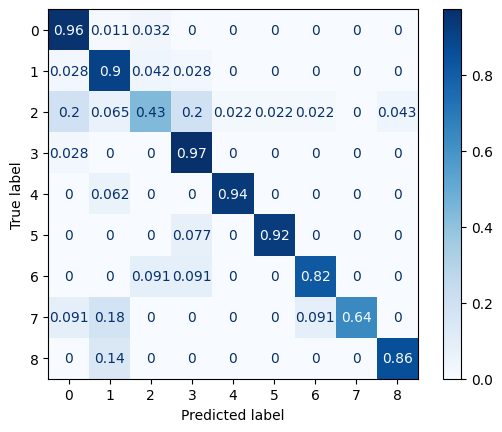

In [ ]:
# mostrar a matrix de confusão grafica do modelo sobre todo o dataset
ConfusionMatrixDisplay.from_estimator(best_model_sg, embeddings_teste, y_test, cmap='Blues', normalize='true')


### RandomForestClassifier

In [ ]:
# Treinar o modelo
# Criar o pipeline com normalização e Random Forest
pipelineRF = Pipeline([
    ('classifier', RandomForestClassifier(random_state=42))
])

# Definir os hiperparâmetros para o Grid Search
param_grid_rf = {
    'classifier__n_estimators': [50, 100],
    'classifier__max_depth': [5, 10, 20],
    'classifier__min_samples_split': [2, 5, 10],
    'classifier__min_samples_leaf': [1, 2, 4],
    'classifier__max_features': ['sqrt', 'log2', 1, 2, 3]
}

# Realizar a busca de hiperparâmetros com validação cruzada
grid_search_rf = GridSearchCV(pipelineRF, param_grid_rf, cv=3, n_jobs=-1, scoring = 'f1_macro')
grid_search_rf.fit(embeddings_treino, y_train)

# Melhor modelo encontrado
best_model_rf = grid_search_rf.best_estimator_
print("Melhores hiperparâmetros:", grid_search_rf.best_params_)

# Mostrar f1 score do melhor estimador
y_pred = best_model_rf.predict(embeddings_teste)
print("F1-Score: ", f1_score(y_test, y_pred, average='macro'))


/usr/local/lib/python3.10/dist-packages/numpy/ma/core.py:2820: RuntimeWarning: invalid value encountered in cast
  _data = np.array(data, dtype=dtype, copy=copy,


Melhores hiperparâmetros: {'classifier__max_depth': 20, 'classifier__max_features': 'sqrt', 'classifier__min_samples_leaf': 2, 'classifier__min_samples_split': 2, 'classifier__n_estimators': 100}
F1-Score:  0.8983558189214494


In [ ]:
# avalie o modelo usando 'classification_report' do sklearn
print(classification_report(y_test, y_pred))

              precision    recall  f1-score   support

           0       0.88      0.93      0.90        94
           1       0.88      0.96      0.92        72
           2       0.95      0.87      0.91        46
           3       0.92      0.97      0.95        36
           4       0.94      0.94      0.94        16
           5       1.00      0.92      0.96        13
           6       1.00      0.82      0.90        11
           7       1.00      0.64      0.78        11
           8       1.00      0.71      0.83         7

    accuracy                           0.91       306
   macro avg       0.95      0.86      0.90       306
weighted avg       0.92      0.91      0.91       306



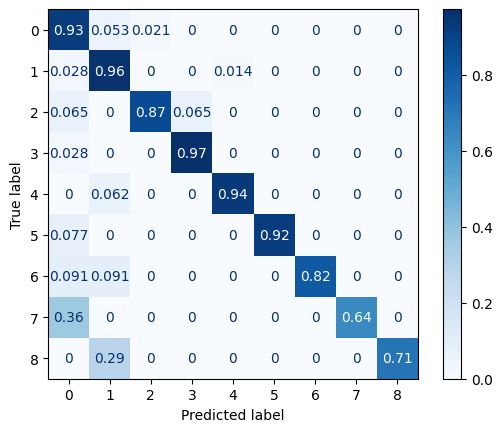

In [ ]:
# mostrar a matrix de confusão grafica do modelo sobre todo o dataset
ConfusionMatrixDisplay.from_estimator(best_model_rf, embeddings_teste, y_test, cmap='Blues', normalize='true')


### XGBoost

In [ ]:
# Treinar o modelo
# Criar o pipeline com normalização e Random Forest
pipelineXG = Pipeline([
    ('classifier', XGBClassifier(random_state=42, eval_metric='logloss'))
])

# Definir os hiperparâmetros para o Grid Search
param_grid_xg = {
    'classifier__n_estimators': [300, 350, 400],
    'classifier__learning_rate': [0.1],
    'classifier__max_depth': [4, 5]
}

# Grid Search com validação cruzada para XGBoost
grid_search_xgb = GridSearchCV(pipelineXG, param_grid_xg, cv=3, scoring='f1_macro', n_jobs=-1)

grid_search_xgb.fit(embeddings_treino, y_train)

# Melhor modelo encontrado
best_model_xg = grid_search_xgb.best_estimator_
print("Melhores hiperparâmetros:", grid_search_xgb.best_params_)

# Mostrar f1 score do melhor estimador
y_pred = best_model_xg.predict(embeddings_teste)
print("F1-Score: ", f1_score(y_test, y_pred, average='macro'))


Melhores hiperparâmetros: {'classifier__learning_rate': 0.1, 'classifier__max_depth': 4, 'classifier__n_estimators': 350}
F1-Score:  0.9009148028185243


In [ ]:
# avalie o modelo usando 'classification_report' do sklearn
print(classification_report(y_test, y_pred))

              precision    recall  f1-score   support

           0       0.98      0.91      0.95        94
           1       0.91      0.97      0.94        72
           2       0.82      0.89      0.85        46
           3       0.85      0.97      0.91        36
           4       1.00      0.94      0.97        16
           5       1.00      0.92      0.96        13
           6       0.90      0.82      0.86        11
           7       1.00      0.73      0.84        11
           8       1.00      0.71      0.83         7

    accuracy                           0.92       306
   macro avg       0.94      0.87      0.90       306
weighted avg       0.92      0.92      0.92       306



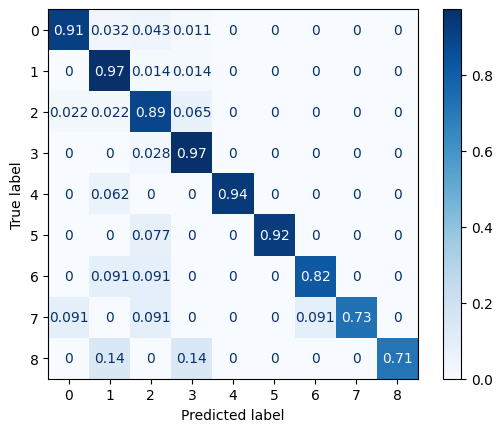

In [ ]:
# mostrar a matrix de confusão grafica do modelo sobre todo o dataset
ConfusionMatrixDisplay.from_estimator(best_model_xg, embeddings_teste, y_test, normalize='true', cmap='Blues')

### Model Ensemble

Relatório de Classificação - Ensemble (Voting Classifier):
              precision    recall  f1-score   support

           0       0.90      0.94      0.92        94
           1       0.92      0.96      0.94        72
           2       0.89      0.89      0.89        46
           3       0.92      0.97      0.95        36
           4       1.00      0.94      0.97        16
           5       1.00      0.92      0.96        13
           6       1.00      0.82      0.90        11
           7       1.00      0.73      0.84        11
           8       1.00      0.71      0.83         7

    accuracy                           0.92       306
   macro avg       0.96      0.88      0.91       306
weighted avg       0.92      0.92      0.92       306

Matriz de Confusão - Ensemble (Voting Classifier)


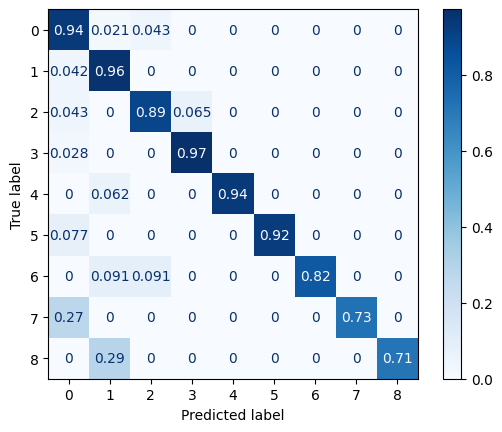

In [ ]:
from pprint import PrettyPrinter
# Criar Ensemble com Voting Classifier (usando os modelos já treinados)
voting_clf = VotingClassifier(
    estimators=[
        ('sg', best_model_sg),  # Usando os melhores estimadores já ajustados
        ('rf', best_model_rf),
        ('xg', best_model_xg)
    ],
    voting='hard'  # Usar 'hard' para voto majoritário ou 'soft' para média das probabilidades
)

# Ajustar o ensemble com o conjunto de treino (fit)
voting_clf.fit(embeddings_treino, y_train)

# Fazer previsões com o ensemble
y_pred_ensemble = voting_clf.predict(embeddings_teste)

# Avaliar Ensemble

print("Relatório de Classificação - Ensemble (Voting Classifier):")
print(classification_report(y_test, y_pred_ensemble))

# Matriz de Confusão para o Ensemble
print('Matriz de Confusão - Ensemble (Voting Classifier)')
ConfusionMatrixDisplay.from_estimator(voting_clf, embeddings_teste, y_test, cmap='Blues', normalize='true')


In [ ]:
# Avalia o ensemble frente aos modelos

for clf, label in zip([best_model_sg, best_model_rf, best_model_xg, voting_clf], ['SGD', 'Random Forest', 'XGBoost', 'Ensemble']):
    scores = cross_val_score(clf, embeddings_treino, y_train, scoring='f1_macro', cv=3, n_jobs=-1)
    print(f"{label} : {scores.mean():0.3f} (+/- {scores.std():0.3f})")



SGD : 0.826 (+/- 0.070)
Random Forest : 0.812 (+/- 0.089)
XGBoost : 0.821 (+/- 0.084)
Ensemble : 0.826 (+/- 0.082)


### Análise dos erros

In [ ]:
# Dataframe para conferência das previsões e respectivas probabilidades

prob_pred = best_model_xg.predict_proba(embeddings_teste)

df_check = pd.DataFrame(X_test)
df_check['target'] = y_test
df_check['prediction'] = best_model_xg.predict(embeddings_teste)
df_check['prob_0'] = np.round(prob_pred[0:,0],6).tolist()
df_check['prob_1'] = np.round(prob_pred[0:,1],6).tolist()
df_check['prob_2'] = np.round(prob_pred[0:,2],6).tolist()
df_check['prob_3'] = np.round(prob_pred[0:,3],6).tolist()
df_check['prob_4'] = np.round(prob_pred[0:,4],6).tolist()
df_check['prob_5'] = np.round(prob_pred[0:,5],6).tolist()
df_check['prob_6'] = np.round(prob_pred[0:,6],6).tolist()
df_check['prob_7'] = np.round(prob_pred[0:,7],6).tolist()
df_check['prob_8'] = np.round(prob_pred[0:,8],6).tolist()
df_check.head()

# Listar as previsões erradas
df_check[df_check['target'] != df_check['prediction']]


,Demanda,target,prediction,prob_0,prob_1,prob_2,prob_3,prob_4,prob_5,prob_6,prob_7,prob_8
1448,Desde o dia 33/33/3333 preenchi o formulário o...,0,2,0.018652,0.040471,0.819371,0.002855,0.049173,0.040995,0.020294,0.004570,0.003620
127,Tenho registro na SUSEP de vida e previdencia...,0,1,0.418016,0.448116,0.066204,0.003524,0.016696,0.025516,0.003363,0.008544,0.010021
494,Ao baixar o aplicativo da carteirinha da Susep...,0,2,0.401213,0.021880,0.495655,0.006898,0.008109,0.019594,0.021847,0.021293,0.003512
1016,Quero denunciar a empresa Corretora de Seguros...,0,1,0.231514,0.550456,0.186041,0.005640,0.007984,0.004503,0.005477,0.003337,0.005048
1122,Em resposta ao chamado/protocolo 33333.333333/...,2,1,0.006433,0.345095,0.237431,0.091105,0.020236,0.054060,0.056353,0.016982,0.172305
1428,DPVATRealizei a solicitação do meu seguro Dpva...,8,1,0.071879,0.793511,0.042262,0.005467,0.001515,0.001383,0.000663,0.001442,0.081877
1370,"Bom dia, Somos da Secretaria de Estado de Infr...",7,6,0.035235,0.022538,0.158255,0.001141,0.003978,0.002020,0.732166,0.041631,0.003035
966,Gostaria de informação acerca da verificação d...,7,2,0.021300,0.021152,0.763767,0.001078,0.001954,0.007902,0.006695,0.173976,0.002177
1426,Boa noite!! Venha através desse relato demonst...,1,3,0.009215,0.302634,0.323057,0.334882,0.001840,0.007893,0.002527,0.001371,0.016581
1293,"Boa Tarde,Sou Auxiliar do Ministério Público d...",6,2,0.013237,0.130199,0.799402,0.003393,0.013044,0.004620,0.020362,0.009407,0.006337


In [ ]:
# Erros envolvendo a classe 2
df_check[(df_check['target'] != df_check['prediction']) & ((df_check['target'] == 2) | (df_check['prediction'] == 2))].shape[0]

14

In [ ]:
# Erros sem envolver a classe 2
df_check[(df_check['target'] != df_check['prediction']) & ((df_check['target'] != 2) & (df_check['prediction'] != 2))].shape[0]

11

In [ ]:
df_check[(df_check['target'] != df_check['prediction']) & ((df_check['target'] != 2) & (df_check['prediction'] != 2))]

,Demanda,target,prediction,prob_0,prob_1,prob_2,prob_3,prob_4,prob_5,prob_6,prob_7,prob_8
127,Tenho registro na SUSEP de vida e previdencia...,0,1,0.418016,0.448116,0.066204,0.003524,0.016696,0.025516,0.003363,0.008544,0.010021
1016,Quero denunciar a empresa Corretora de Seguros...,0,1,0.231514,0.550456,0.186041,0.005640,0.007984,0.004503,0.005477,0.003337,0.005048
1428,DPVATRealizei a solicitação do meu seguro Dpva...,8,1,0.071879,0.793511,0.042262,0.005467,0.001515,0.001383,0.000663,0.001442,0.081877
1370,"Bom dia, Somos da Secretaria de Estado de Infr...",7,6,0.035235,0.022538,0.158255,0.001141,0.003978,0.002020,0.732166,0.041631,0.003035
1426,Boa noite!! Venha através desse relato demonst...,1,3,0.009215,0.302634,0.323057,0.334882,0.001840,0.007893,0.002527,0.001371,0.016581
785,"Considerando que a empresa ESSOR SEGUROS S.A.,...",0,3,0.021668,0.172365,0.037576,0.454879,0.003794,0.006384,0.033876,0.266177,0.003280
1367,Após abertura de sinistro a seguradora sompo n...,6,1,0.000876,0.533944,0.244883,0.045032,0.001536,0.052908,0.111430,0.001505,0.007887
1526,Registro de morte e Invalidez AcidentesFale aq...,8,3,0.021452,0.219950,0.278002,0.388657,0.009223,0.021450,0.019777,0.037283,0.004205
433,BOM DIA! SOU CORRETOR DE SEGUROS - CPF 333.333...,0,1,0.084539,0.743275,0.077673,0.015516,0.004301,0.001454,0.056379,0.001309,0.015554
927,"Bom dia, Sou Paulo Fernando , Procurador da Fa...",7,0,0.506467,0.362287,0.118683,0.000928,0.001214,0.001166,0.004018,0.002982,0.002255


In [ ]:
y_mapping

{'Cadastro': 0,
 'Seguro de Pessoas': 1,
 'Não identificada': 2,
 'Seguro de Automoveis': 3,
 'Previdência Complementar Aberta': 4,
 'Seguro de Danos': 5,
 'Outros': 6,
 'Seguro Garantia': 7,
 'DPVAT/SPVAT': 8}

### Salvar o melhor modelo

In [ ]:
# Salvar o Modelo Ensemble
import joblib
joblib.dump(best_model_xg, 'best_model.pkl')
print("Modelo SGD salvo como 'best_model_xg.pkl'")

Modelo SGD salvo como 'best_model_xg.pkl'
